# Derived Depth Estimates via Overlapping Variance Between Tasks

In [2]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression
import copy

### Load in Discrimination Data

In [3]:
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination'
# raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalDiscrimMatched/z_scored_RT/'

# final_data = pd.read_csv (raw_dir + '/raw_discrim.csv')
zscored_data = pd.read_csv (zs_dir + 'final_discrim.csv')

In [7]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        list_RTs.append(row["cleaned_RT"])
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

def get_zsRT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_zsRTs = []
    for idx, row in df.iterrows():   
        zsRT = row["z_scored_RT"]
        list_zsRTs.append(zsRT)
    
    list_zsRTs = np.array(list_zsRTs)
    return list_zsRTs, np.mean(list_zsRTs) ,np.std(list_zsRTs), stats.sem(list_zsRTs)

In [8]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str]

    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        try:
            stim_acc_125 = get_accuracy(stim_125_df)
            stim_acc_250 = get_accuracy(stim_250_df)
            stim_acc_1000 = get_accuracy(stim_1000_df)

            stim_RT_125 = get_RT(stim_125_df)
            stim_RT_250 = get_RT(stim_250_df)
            stim_RT_1000 = get_RT(stim_1000_df)

            stim_zsRT_125 = get_zsRT(stim_125_df)
            stim_zsRT_250 = get_zsRT(stim_250_df)
            stim_zsRT_1000 = get_zsRT(stim_1000_df)

            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'zsRT_125': stim_zsRT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'zsRT_250': stim_zsRT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'zsRT_1000': stim_zsRT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        except:
            pass
    
    return stimuli_stats

In [9]:
all_discrim_performance = individual_discrimination_stats(zscored_data)


In [10]:
zscored_data.columns

Index(['Unnamed: 0', 'subjID', 'workerId', 'experimentName', 'versionName',
       'sequenceName', 'url', 'selected_row', 'windowWidth', 'windowHeight',
       'screenWidth', 'screenHeight', 'startDate', 'z_scored_RT', 'cleaned_RT',
       'startTime', 'trial', 'stimulus_0', 'stimulus_1', 'depth_difference',
       'kinect_answer', 'duration', 'actual_depth_0', 'actual_depth_1',
       'discrim_choice', 'trial_RT', 'log_fixation', 'log_sceneDuration1',
       'log_mask1', 'log_sceneDuration2', 'log_mask2', 'experimentTime',
       'totalTime', 'age', 'gender'],
      dtype='object')

## Load Z-scored TAC Verbal Judgement Data


In [11]:
p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'

# x data
with open(p + 'X_125.npy' , 'rb') as f:
    n_TAC_X_125 = np.load(f, allow_pickle=True)
    
with open(p + 'X_250.npy' , 'rb') as f:
    n_TAC_X_250 = np.load(f, allow_pickle=True)

with open(p + 'X_1000.npy' , 'rb') as f:
    n_TAC_X_1000 = np.load(f, allow_pickle=True)
    
# y data 
with open(p + 'z_final_y_125.npy' , 'rb') as f:
    n_TAC_final_y_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_250.npy' , 'rb') as f:
    n_TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_1000.npy' , 'rb') as f:
    n_TAC_final_y_1000= np.load(f, allow_pickle=True)

# std data
with open(p + 'z_std_125.npy' , 'rb') as f:
    n_TAC_std_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_std_250.npy' , 'rb') as f:
    n_TAC_std_250 = np.load(f, allow_pickle=True)

with open(p + 'z_std_1000.npy' , 'rb') as f:
    n_TAC_std_1000 = np.load(f, allow_pickle=True)
    
# ste data
with open(p + 'z_ste_125.npy' , 'rb') as f:
    n_TAC_ste_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_ste_250.npy' , 'rb') as f:
    n_TAC_ste_250 = np.load(f, allow_pickle=True)

with open(p + 'z_ste_1000.npy' , 'rb') as f:
    n_TAC_ste_1000 = np.load(f, allow_pickle=True)

# stim data
with open(p + 'z_final_stim_125.npy' , 'rb') as f:
    n_TAC_final_stim_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_stim_250.npy' , 'rb') as f:
    n_TAC_final_stim_250 = np.load(f, allow_pickle=True)

with open(p + 'z_final_stim_1000.npy' , 'rb') as f:
    n_TAC_final_stim_1000 = np.load(f, allow_pickle=True)

# Code depth discrimination correctness by the verbal judgement data 

Create new 'ground truth' answer based on verbal judgement data

Task: Respond which image's target was closer to you

## VE Data

In [12]:
n_VE_answerkey_125 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_125 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_125[idx0]
    std0 = n_TAC_std_125[idx0]
    ste0 = n_TAC_ste_125[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_125 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_125[idx1]
    std1 = n_TAC_std_125[idx1]
    ste1 = n_TAC_ste_125[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_125[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}

In [13]:
# n_VE_answerkey_125

In [14]:
n_VE_answerkey_250 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_250[idx0]
    std0 = n_TAC_std_250[idx0]
    ste0 = n_TAC_ste_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_250[idx1]
    std1 = n_TAC_std_250[idx1]
    ste1 = n_TAC_ste_250[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_250[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [15]:
# len(n_VE_answerkey_250), n_VE_answerkey_250['depth_discrimination_stimuli/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png']
# n_VE_answerkey_250

In [16]:
n_VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_1000[idx0]
    std0 = n_TAC_std_1000[idx0]

    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_1000[idx1]
    std1 = n_TAC_std_1000[idx1]
    
    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]



    n_VE_answerkey_1000[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [17]:
len(n_VE_answerkey_1000)

156

In [17]:
import pickle
# save answer keys as pickle file 

# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_1000.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_1000, handle)

In [18]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_250.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_250, handle)

### VE Coded Accuracy

In [18]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        try:
            # dataframe for stimulus 0
            stim0_df = df.loc[df['stimulus_0'] == stim0]
            # name of stimulus 1
            other_stim = stim0_df.stimulus_1.unique()[0]
            # dataframe where stimulus 0 is presented SECOND (same trial)
            stim1_df = df.loc[df['stimulus_1'] == stim0]

            # df for a specific discrimination trial (collapsed on stim presentation order)
            stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
            stim_125_df = stim_df[stim_df['duration'] == 125.0]
            stim_250_df = stim_df[stim_df['duration'] == 250.0]
            stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

            stim0_depth = stim_df['actual_depth_0'][0]
            stim1_depth = stim_df['actual_depth_1'][0]
            stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

            stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
            stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
            stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

            # difference between verbal judgements divided by joint variance 
            # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            std0_125 = answerkey_125[stim0]['std0']
            std1_125 = answerkey_125[stim0]['std1']
            joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
            JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

            std0_250 = answerkey_250[stim0]['std0']
            std1_250 = answerkey_250[stim0]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

            std0_1000 = answerkey_1000[stim0]['std0']
            std1_1000 = answerkey_1000[stim0]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
            if stim_acc_125[-1] == 'pos':
                VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_250[-1] == 'pos':
                VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_1000[-1] == 'pos':
                VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_125': [answerkey_125[stim0]['stimulus_0_avg_estim'], answerkey_125[stim0]['stimulus_1_avg_estim']],
                                    'VE_250': [answerkey_250[stim0]['stimulus_0_avg_estim'], answerkey_250[stim0]['stimulus_1_avg_estim']],
                                    'VE_1000': [answerkey_1000[stim0]['stimulus_0_avg_estim'], answerkey_1000[stim0]['stimulus_1_avg_estim']],
                                    'VE_avg_depth_125': (answerkey_125[stim0]['stimulus_0_avg_estim'] + answerkey_125[stim0]['stimulus_1_avg_estim'])/2,
                                    'VE_avg_depth_250': (answerkey_250[stim0]['stimulus_0_avg_estim'] + answerkey_250[stim0]['stimulus_1_avg_estim'])/2,
                                    'VE_avg_depth_1000': (answerkey_1000[stim0]['stimulus_0_avg_estim'] + answerkey_1000[stim0]['stimulus_1_avg_estim'])/2,
                                    'VE_depthdifference_125': VE_depthdifference_125, 
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': get_RT(stim_125_df),
                                    'RT_250': get_RT(stim_250_df),
                                    'RT_1000': get_RT(stim_1000_df),
                                    'zsRT_125': get_zsRT(stim_125_df),
                                    'zsRT_250': get_zsRT(stim_250_df),
                                    'zsRT_1000': get_zsRT(stim_1000_df),
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000,
                                    'kinect_answer_125': answerkey_125[stim0]['kinect_answer'],
                                    'kinect_answer_250': answerkey_250[stim0]['kinect_answer'],
                                    'kinect_answer_1000': answerkey_1000[stim0]['kinect_answer']}
            

        except:
            print(stim0)

    return stimuli_stats
    

In [19]:
n_all_VE_discrim_performance = main_VE_accuracy(zscored_data, n_VE_answerkey_125, n_VE_answerkey_250, n_VE_answerkey_1000) 

nan


In [20]:
n_VE_estim_diff_125 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_250 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_1000 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in n_all_VE_discrim_performance]

n_VE_accuracy_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in n_all_VE_discrim_performance]

n_VE_ste_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in n_all_VE_discrim_performance]

n_avg_RT_125 = [n_all_VE_discrim_performance[elem]['RT_125'][1] for elem in n_all_VE_discrim_performance]
n_avg_RT_250 = [n_all_VE_discrim_performance[elem]['RT_250'][1] for elem in n_all_VE_discrim_performance]
n_avg_RT_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in n_all_VE_discrim_performance]

n_avg_RT_ste_125 = [n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_250 = [n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_avg_zsRT_125 = [n_all_VE_discrim_performance[elem]['zsRT_125'][1] for elem in n_all_VE_discrim_performance]
n_avg_zsRT_250 = [n_all_VE_discrim_performance[elem]['zsRT_250'][1] for elem in n_all_VE_discrim_performance]
n_avg_zsRT_1000 = [n_all_VE_discrim_performance[elem]['zsRT_1000'][1] for elem in n_all_VE_discrim_performance]

n_avg_zsRT_ste_125 = [n_all_VE_discrim_performance[elem]['zsRT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_zsRT_ste_250 = [n_all_VE_discrim_performance[elem]['zsRT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_zsRT_ste_1000 = [n_all_VE_discrim_performance[elem]['zsRT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_JV_125 = [n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in n_all_VE_discrim_performance]
n_JV_250 = [n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in n_all_VE_discrim_performance]
n_JV_1000 = [n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in n_all_VE_discrim_performance]

n_kinectanswer_125 = [n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_250 = [n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_1000 = [n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in n_all_VE_discrim_performance]

n_stim = [elem for elem in n_all_VE_discrim_performance]

In [21]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

m: [0.24756021]
b: 0.5475760594800402
R-squared:  0.5403180697029255


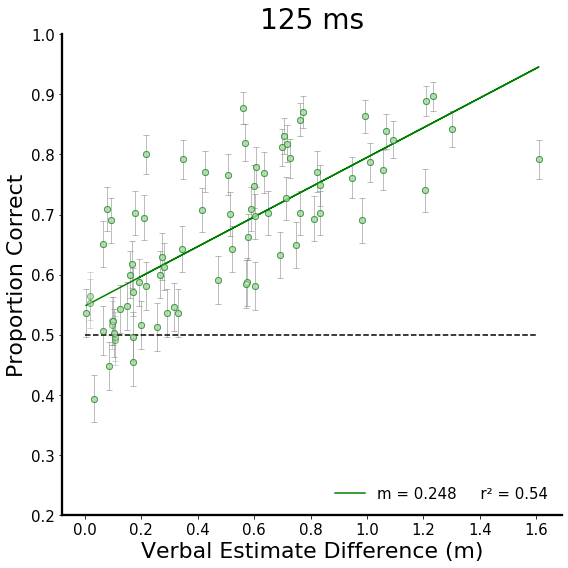

In [22]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)



#run regression
VE_X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
VE_PC_125 = n_VE_accuracy_125
VE_PC_reg_125 = LinearRegression().fit(VE_X_125, VE_PC_125)

#Generated Predictions
PC_predicted_125 = VE_PC_reg_125.predict(VE_X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_125, VE_PC_125,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_125));


plt.plot(VE_X_125, VE_PC_125, 'o', color='green', alpha = 0.3);
plt.plot(VE_X_125, PC_predicted_125,color='green', label = 'm = ' + str(round(VE_PC_reg_125.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0.2,1)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_125.coef_))
print("b: {0}".format(VE_PC_reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_125.score(VE_X_125, VE_PC_125))

legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('125 ms', fontsize=28)

fig.tight_layout()

plt.show();

In [23]:
# PC_predicted_125

m: [0.25577685]
b: 0.5872489111834709
R-squared:  0.5589028856401494


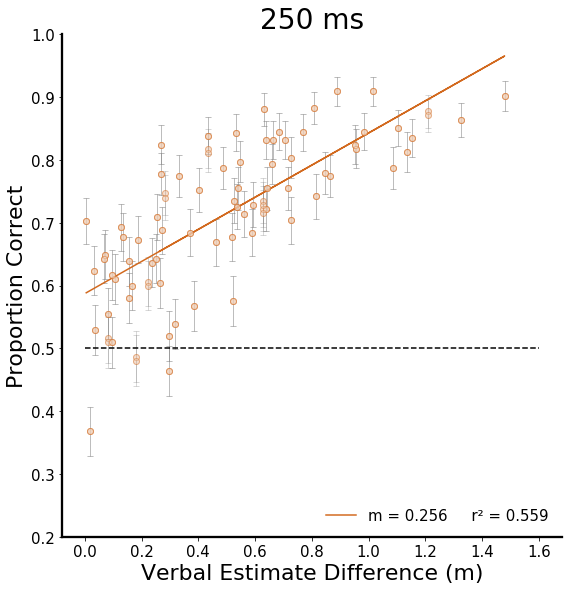

In [24]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
VE_X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
VE_PC_250 = n_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));


plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')
plt.ylim(0.2,1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))

legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('250 ms', fontsize=28)


plt.show();

In [25]:
n_stim.index('depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png')

        

39

m: [0.29241041]
b: 0.6053232154678307
R-squared:  0.5760584510087943


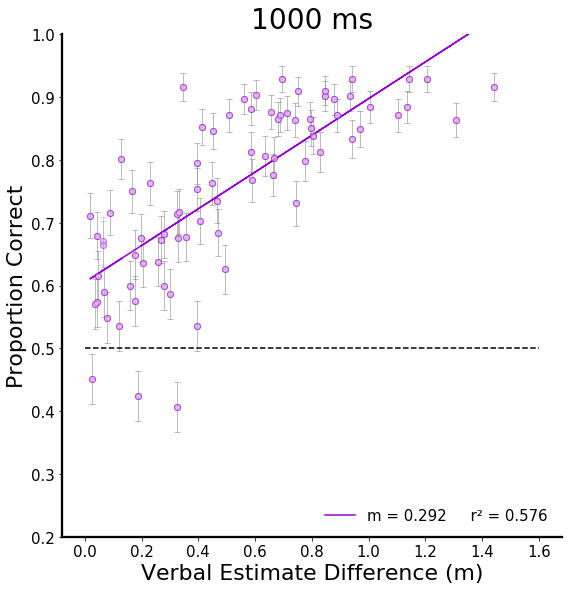

In [26]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


VE_X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
VE_PC_1000 = n_VE_accuracy_1000
VE_PC_reg_1000 = LinearRegression().fit(VE_X_1000, VE_PC_1000)

#Generated Predictions
PC_predicted_1000 = VE_PC_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values

r = np.sqrt(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)))

plt.errorbar(VE_X_1000, VE_PC_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_1000));
plt.plot(VE_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(VE_PC_reg_1000.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')
plt.ylim(0.2,1)

# plt.plot(VE_X_1000[2], VE_PC_1000[2], 'o', color='black', alpha=1)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_1000.coef_))
print("b: {0}".format(VE_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000))

plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.title("1000 ms: Accuracy", fontsize = 20)

# plt.xticks(np.arange(-1,1.2, 0.2))
# plt.yticks(np.arange(-1,1.2, 0.2))

fig.tight_layout()

plt.title('1000 ms', fontsize=28)


plt.show();

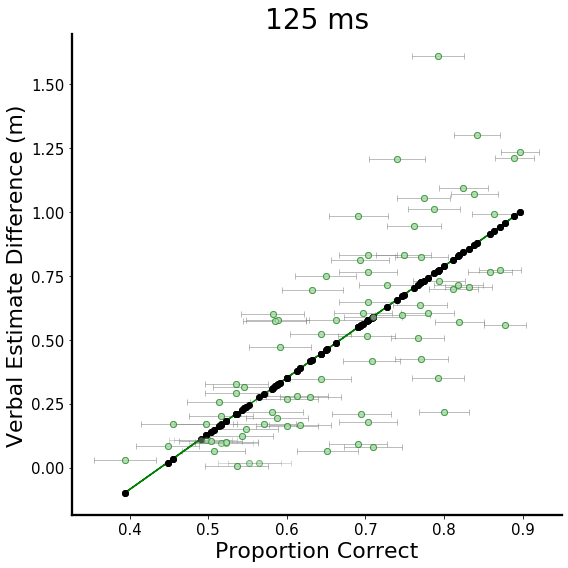

In [31]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regressio
x_pc_125 = np.array(np.abs(n_VE_accuracy_125).reshape(-1,1))
y_diff_125 = [abs(elem) for elem in n_VE_estim_diff_125]


reg_125 = LinearRegression().fit(x_pc_125, y_diff_125)


#Generated Predictions
estimdiff_predicted_125 = reg_125.predict(x_pc_125)
#Plot Our Actual and Predicted Values
plt.errorbar(x_pc_125, y_diff_125,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, xerr = np.array(n_VE_ste_125));


plt.plot(x_pc_125, y_diff_125, 'o', color='green', alpha = 0.3);
plt.plot(x_pc_125, estimdiff_predicted_125,color='green')
plt.ylabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.xlabel("Proportion Correct", fontsize = 22)

plt.plot(x_pc_125, new_VE_diffs_125, 'o', color='black')
# plt.plot(x_pc_125[63], new_VE_diffs_125[63], 'o', color='red')
# plt.plot(x_pc_125[102], new_VE_diffs_125[102], 'o', color='violet')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('125 ms', fontsize=28)

fig.tight_layout()



In [28]:
VE_per_trial_125 = [n_all_VE_discrim_performance[elem]['VE_125'] for elem in n_all_VE_discrim_performance]
VE_per_trial_250 = [n_all_VE_discrim_performance[elem]['VE_250'] for elem in n_all_VE_discrim_performance]
VE_per_trial_1000 = [n_all_VE_discrim_performance[elem]['VE_1000'] for elem in n_all_VE_discrim_performance]


In [29]:
# model_diff_prediction = abs(VE0*z - VE1*z)
# z = model_diff_prediction/abs(VE0-VE1)
scale_coeff_125 = [estimdiff_predicted_125[i]/abs(VE_per_trial_125[i][0] - VE_per_trial_125[i][1]) for i in range(len(VE_per_trial_125))]

# newVE0 = VE0*z
# newVE1 = VE1*z
new_VEs_125 = [[VE_per_trial_125[i][0]*scale_coeff_125[i], VE_per_trial_125[i][1]*scale_coeff_125[i]] for i in range(len(VE_per_trial_125))]

new_VE_diffs_125 = []

i = 0
for elem in new_VEs_125:
    if estimdiff_predicted_125[i] > 0:
        new_VE_diffs_125.append(abs(elem[0]-elem[1]))
    else:
        if elem[0]-elem[1] < 0:
            new_VE_diffs_125.append(elem[0]-elem[1])
        else:
            new_VE_diffs_125.append(elem[1]-elem[0])
    i += 1

# new_VE_diffs_125 = [elem[0]-elem[1] for elem in new_VEs_125]

In [30]:
# for elem in new_VE_diffs_125:
#     if elem == -0.10566446161549137:
#         print(elem)

In [32]:
for i in range(len(estimdiff_predicted_125)):
    if (round(estimdiff_predicted_125[i], 4) == round(new_VE_diffs_125[i], 4)) == False:
        print('False: ', i)
#     print(estimdiff_predicted_125[i])
#     print(new_VE_diffs_125[i])
    

In [33]:
VE_per_trial_125[63], new_VEs_125[63], new_VE_diffs_125[63], scale_coeff_125[63]

([0.3627493130785678, 0.3315499303090125],
 [-1.1536017446918478, -1.0543826391039832],
 -0.09921910558786462,
 -3.1801624513124565)

In [34]:
estimdiff_predicted_125[63]

-0.09921910558786462

In [35]:
estimdiff_predicted_125[63]/abs(VE_per_trial_125[63][0] - VE_per_trial_125[63][1])

-3.1801624513124565

In [36]:
VE_per_trial_125[63][0] - VE_per_trial_125[63][1] 

0.031199382769555306

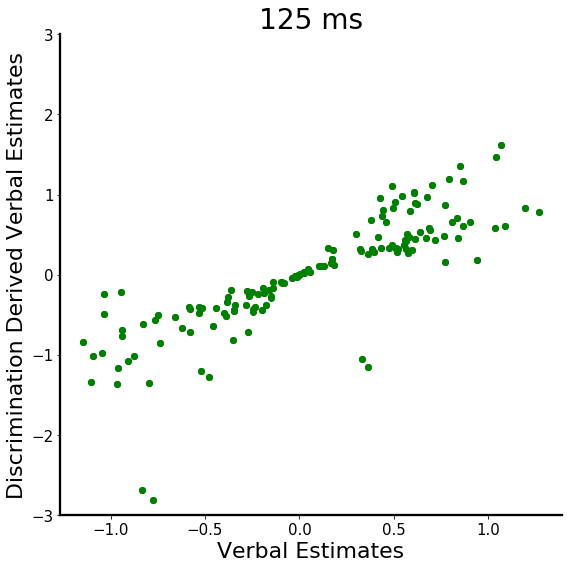

In [37]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.plot(np.array(VE_per_trial_125).flatten(), np.array(new_VEs_125).flatten(), 'o', color='green')
plt.ylim(-3,3)
plt.xlabel('Verbal Estimates', fontsize=22)
plt.ylabel('Discrimination Derived Verbal Estimates', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('125 ms', fontsize=28)

fig.tight_layout()

plt.show();

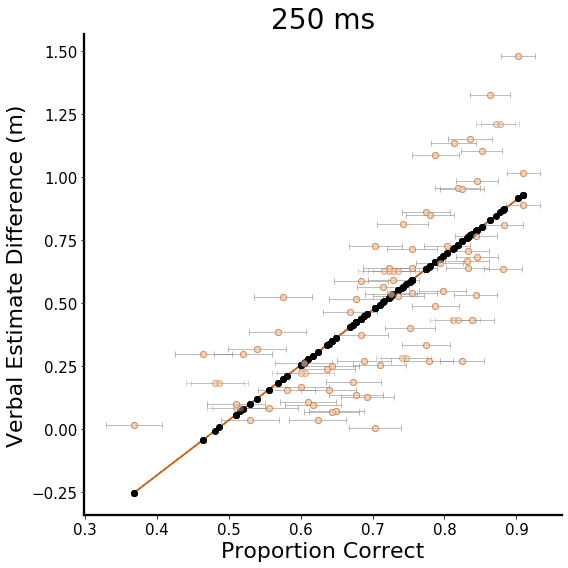

In [40]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regressio
x_pc_250 = np.array(np.abs(n_VE_accuracy_250).reshape(-1,1))
y_diff_250 = [abs(elem) for elem in n_VE_estim_diff_250]


reg_250 = LinearRegression().fit(x_pc_250, y_diff_250)


#Generated Predictions
estimdiff_predicted_250 = reg_250.predict(x_pc_250)
#Plot Our Actual and Predicted Values
plt.errorbar(x_pc_250, y_diff_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, xerr = np.array(n_VE_ste_250));


plt.plot(x_pc_250, y_diff_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(x_pc_250, estimdiff_predicted_250,color='chocolate')
plt.ylabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.xlabel("Proportion Correct", fontsize = 22)

plt.plot(x_pc_250, new_VE_diffs_250, 'o', color='black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('250 ms', fontsize=28)

fig.tight_layout()


In [41]:
# model_diff_prediction = abs(VE0*z - VE1*z)
# z = model_diff_prediction/abs(VE0-VE1)
scale_coeff_250 = [estimdiff_predicted_250[i]/abs(VE_per_trial_250[i][0] - VE_per_trial_250[i][1]) for i in range(len(VE_per_trial_250))]

# newVE0 = VE0*z
# newVE1 = VE1*z
new_VEs_250 = [[VE_per_trial_250[i][0]*scale_coeff_250[i], VE_per_trial_250[i][1]*scale_coeff_250[i]] for i in range(len(VE_per_trial_250))]

new_VE_diffs_250 = []
i = 0
for elem in new_VEs_250:
    if estimdiff_predicted_250[i] > 0:
        new_VE_diffs_250.append(abs(elem[0]-elem[1]))
    else:
        if elem[0]-elem[1] < 0:
            new_VE_diffs_250.append(elem[0]-elem[1])
        else:
            new_VE_diffs_250.append(elem[1]-elem[0])
    i += 1
    
# new_VE_diffs_250 = [abs(elem[0]-elem[1]) for elem in new_VEs_250]

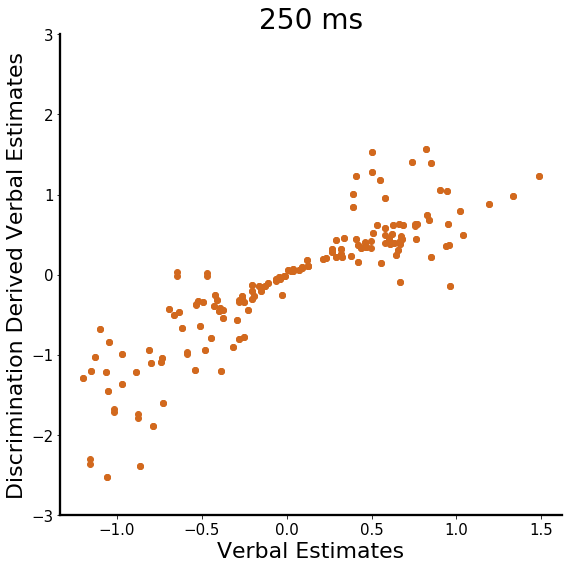

In [42]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.plot(np.array(VE_per_trial_250).flatten(), np.array(new_VEs_250).flatten(), 'o', color='chocolate')
plt.ylim(-3,3)
plt.xlabel('Verbal Estimates', fontsize=22)
plt.ylabel('Discrimination Derived Verbal Estimates', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('250 ms', fontsize=28)

fig.tight_layout()

plt.show();

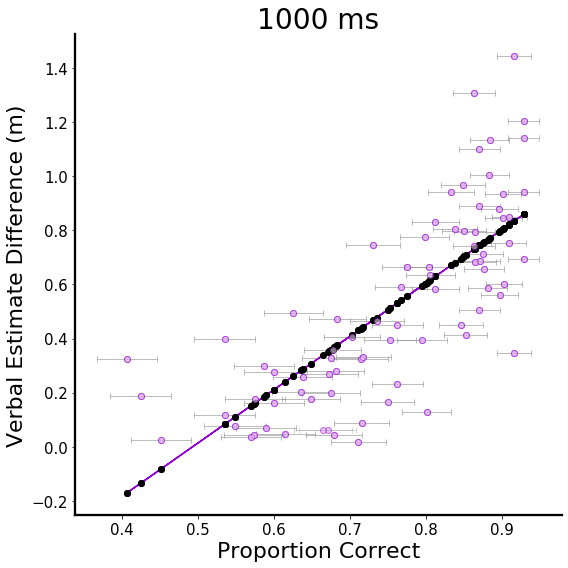

In [45]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regressio
x_pc_1000 = np.array(np.abs(n_VE_accuracy_1000).reshape(-1,1))
y_diff_1000 = [abs(elem) for elem in n_VE_estim_diff_1000]


reg_1000 = LinearRegression().fit(x_pc_1000, y_diff_1000)


#Generated Predictions
estimdiff_predicted_1000 = reg_1000.predict(x_pc_1000)
#Plot Our Actual and Predicted Values
plt.errorbar(x_pc_1000, y_diff_1000,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, xerr = np.array(n_VE_ste_1000));


plt.plot(x_pc_1000, y_diff_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(x_pc_1000, estimdiff_predicted_1000,color='darkviolet')
plt.ylabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.xlabel("Proportion Correct", fontsize = 22)

plt.plot(x_pc_1000, new_VE_diffs_1000, 'o', color='black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('1000 ms', fontsize=28)

fig.tight_layout()


In [46]:
# model_diff_prediction = abs(VE0*z - VE1*z)
# z = model_diff_prediction/abs(VE0-VE1)
scale_coeff_1000 = [estimdiff_predicted_1000[i]/abs(VE_per_trial_1000[i][0] - VE_per_trial_1000[i][1]) for i in range(len(VE_per_trial_1000))]

# newVE0 = VE0*z
# newVE1 = VE1*z
new_VEs_1000 = [[VE_per_trial_1000[i][0]*scale_coeff_1000[i], VE_per_trial_1000[i][1]*scale_coeff_1000[i]] for i in range(len(VE_per_trial_1000))]

new_VE_diffs_1000 = []
i = 0
for elem in new_VEs_1000:
    if estimdiff_predicted_1000[i] > 0:
        new_VE_diffs_1000.append(abs(elem[0]-elem[1]))
    else:
        if elem[0]-elem[1] < 0:
            new_VE_diffs_1000.append(elem[0]-elem[1])
        else:
            new_VE_diffs_1000.append(elem[1]-elem[0])
    i += 1
    
# new_VE_diffs_1000 = [abs(elem[0]-elem[1]) for elem in new_VEs_1000]

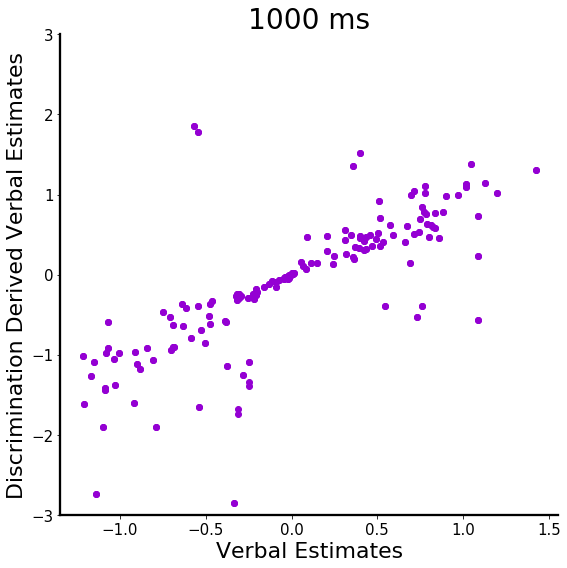

In [47]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.plot(np.array(VE_per_trial_1000).flatten(), np.array(new_VEs_1000).flatten(), 'o', color='darkviolet')
plt.ylim(-3,3)
plt.xlabel('Verbal Estimates', fontsize=22)
plt.ylabel('Discrimination Derived Verbal Estimates', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('1000 ms', fontsize=28)

fig.tight_layout()

plt.show();

In [48]:
kinect_depth = []

for stim in n_stim:
    stim_df = zscored_data.loc[zscored_data['stimulus_0']==stim]
    kinect_depth.append(stim_df['actual_depth_0'].unique()[0])


In [49]:
s0_VEs_125 = [elem[0] for elem in new_VEs_125]
s0_VEs_250 = [elem[0] for elem in new_VEs_250]
s0_VEs_1000 = [elem[0] for elem in new_VEs_1000]

In [50]:
outlier_range_125 = [np.mean(np.array(s0_VEs_125)) - 2*np.std(np.array(s0_VEs_125)), 
                     np.mean(np.array(s0_VEs_125)) + 2*np.std(np.array(s0_VEs_125))]

outlier_range_250 = [np.mean(np.array(s0_VEs_250)) - 2*np.std(np.array(s0_VEs_250)), 
                     np.mean(np.array(s0_VEs_250)) + 2*np.std(np.array(s0_VEs_250))]

outlier_range_1000 = [np.mean(np.array(s0_VEs_1000)) - 2*np.std(np.array(s0_VEs_1000)), 
                      np.mean(np.array(s0_VEs_1000)) + 2*np.std(np.array(s0_VEs_1000))]

In [51]:
def remove_outliers(data, y, stim, outlier_range):
    trunc_data = []
    trunc_y = []
    # need to keep track of the stimulus that corresponds to the depth estimates/kinect output
    trunc_stim = []
    
    for i in range(len(data)):
        if data[i] > outlier_range[0]:
            if data[i] < outlier_range[1]:
                trunc_data.append(data[i])
                trunc_y.append(y[i])
                trunc_stim.append(stim[i])
        
        
    return trunc_data, trunc_y, trunc_stim

In [52]:
cleaned_s0_VEs_125, kinect_depth_125, stim_125 = remove_outliers(s0_VEs_125, kinect_depth, n_stim, outlier_range_125)
cleaned_s0_VEs_250, kinect_depth_250, stim_250 = remove_outliers(s0_VEs_250, kinect_depth, n_stim, outlier_range_250)
cleaned_s0_VEs_1000, kinect_depth_1000, stim_1000 = remove_outliers(s0_VEs_1000, kinect_depth, n_stim, outlier_range_1000)

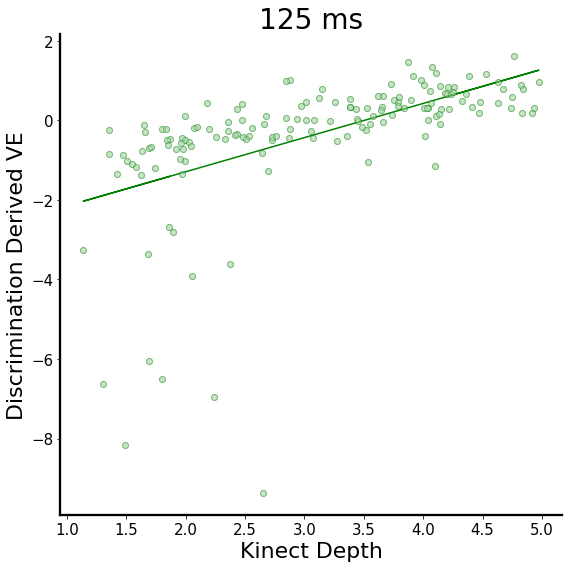

In [53]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X_125 = np.array(kinect_depth_125).reshape(-1,1)
y_125 = cleaned_s0_VEs_125


reg_125 = LinearRegression().fit(X_125, y_125)


#Generated Predictions
predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3);


plt.plot(X_125, y_125, 'o', color='green', alpha = 0.3);
plt.plot(X_125, predicted_125,color='green')
plt.ylabel("Discrimination Derived VE", fontsize = 22)
plt.xlabel("Kinect Depth", fontsize = 22)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('125 ms', fontsize=28)

fig.tight_layout()

residuals_125 = copy.deepcopy(y_125 - predicted_125)


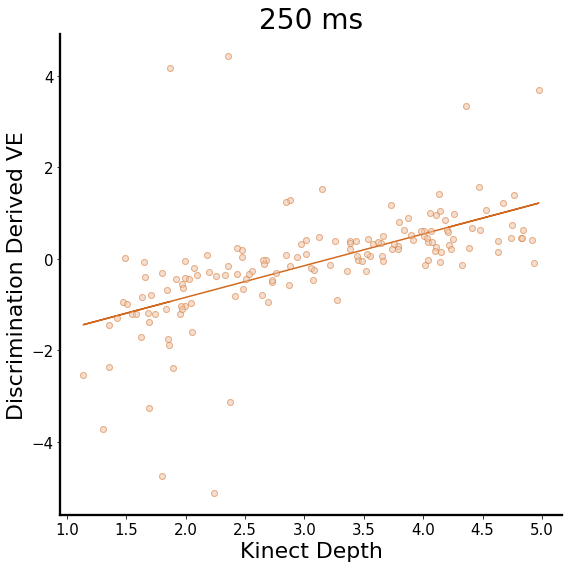

In [54]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X_250 = np.array(kinect_depth_250).reshape(-1,1)
y_250 = cleaned_s0_VEs_250


reg_250 = LinearRegression().fit(X_250, y_250)


#Generated Predictions
predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3);


plt.plot(X_250, y_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(X_250, predicted_250,color='chocolate')
plt.ylabel("Discrimination Derived VE", fontsize = 22)
plt.xlabel("Kinect Depth", fontsize = 22)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('250 ms', fontsize=28)

fig.tight_layout()

residuals_250 = copy.deepcopy(y_250 - predicted_250)


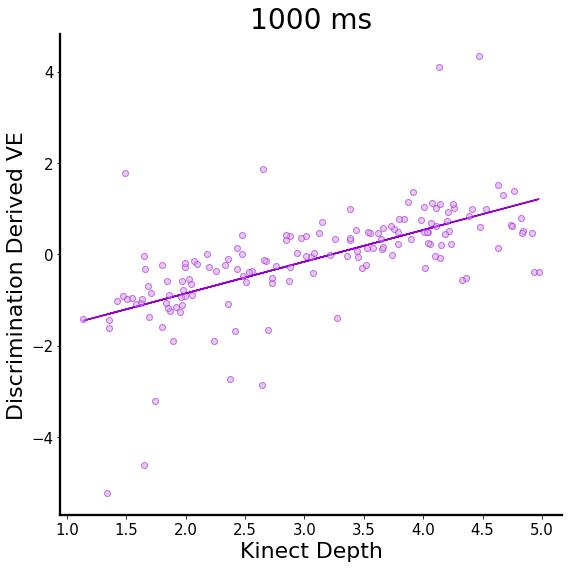

In [55]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X_1000 = np.array(kinect_depth_1000).reshape(-1,1)
y_1000 = cleaned_s0_VEs_1000


reg_1000 = LinearRegression().fit(X_1000, y_1000)


#Generated Predictions
predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.errorbar(X_1000, y_1000,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3);


plt.plot(X_1000, y_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(X_1000, predicted_1000,color='darkviolet')
plt.ylabel("Discrimination Derived VE", fontsize = 22)
plt.xlabel("Kinect Depth", fontsize = 22)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('1000 ms', fontsize=28)

fig.tight_layout()

residuals_1000 = copy.deepcopy(y_1000 - predicted_1000)

In [56]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/discrimination_derived_VE/'



np.save(dest + 'stimuli_125.npy', stim_125, allow_pickle=True)
np.save(dest + 'stimuli_250.npy', stim_250, allow_pickle=True)
np.save(dest + 'stimuli_1000.npy', stim_1000, allow_pickle=True)

np.save(dest + 'derivedVE_125.npy', cleaned_s0_VEs_125, allow_pickle=True)
np.save(dest + 'derivedVE_250.npy', cleaned_s0_VEs_250, allow_pickle=True)
np.save(dest + 'derivedVE_1000.npy', cleaned_s0_VEs_1000, allow_pickle=True)

np.save(dest + 'residuals_derivedVE_125.npy', residuals_125, allow_pickle=True)
np.save(dest + 'residuals_derivedVE_250.npy', residuals_250, allow_pickle=True)
np.save(dest + 'residuals_derivedVE_1000.npy', residuals_1000, allow_pickle=True)

(154, 154)